# **Amazon Reviews Sentiment Analysis**

# *Method 1: TfIdf and Logistic Regression*

**Import libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
import re
import string
import time
import joblib
import bz2

**Function to extract text and labels**

In [2]:
# Get text and labels from raw file

def get_data(filepath):
    reviews = []
    text = []
    label = []
    with bz2.BZ2File(filepath,"r") as f:
        for line in f:
            x = line.decode()
            x = x.partition("_label__")
            reviews.append(x[2:])
        pass
    f.close()
    for review in reviews:
        label.append(review[0].split()[0])
        text.append(' '.join(review[0].split()[1:]))
        
    return text,label

**Function to create dataframe from extracted text and labels**

In [3]:
# Create dataframe

def create_dataframe(filepath):
    text,label = get_data(filepath)
    data = {"text":text,"label":label}
    df = pd.DataFrame(data)
    print("Number of records:",len(df))
    df.dropna(inplace=True) # remove null records
    df.reset_index(drop=True,inplace=True)
    df["label"] = df["label"].astype(int)
    print("Number of records after removing nulls:",len(df))
    
    return df

**Create train dataframe**

In [4]:
# Load train data

df = create_dataframe("/kaggle/input/amazonreviews/train.ft.txt.bz2")

# Change labels to 0 and 1
df['label'] = df['label'].apply(lambda x: 0 if x==1 else 1)

df.head()

Number of records: 3600000
Number of records after removing nulls: 3600000


,text,label
0,Stuning even for the non-gamer: This sound tra...,1
1,The best soundtrack ever to anything.: I'm rea...,1
2,Amazing!: This soundtrack is my favorite music...,1
3,Excellent Soundtrack: I truly like this soundt...,1
4,"Remember, Pull Your Jaw Off The Floor After He...",1


In [5]:
df = df[:500000]

**Function to pre-process text**

In [6]:
# Preprocessing function

def preprocess_text(data):
    # convert to string
    data = str(data)
    # convert to lowercase
    data = data.lower()
    # remove special characters
    data = re.sub(r'[^\w ]+','',data)
    # remove links
    data = re.sub(r'(http|https)?://\S+|www\.\S+','',data)
    # remove non-ascii
    data = ''.join(word for word in data if ord(word) < 128)
    # remove punctuation
    data = data.translate(str.maketrans('','',string.punctuation))
    # remove digits
    data = re.sub(r'[\d]+','',data)
    # remove single letters
    data = ' '.join(word for word in data.split() if len(word)>1)
    # remove multiple spaces
    data = ' '.join(data.split())
    
    return data

**Apply the pre-process function on the text column**

In [7]:
# Apply preprocessing function to dataframe

df_copy = df.copy()
df_copy.loc[:,"text"] = df_copy["text"].apply(preprocess_text)
df_copy.head()

,text,label
0,stuning even for the nongamer this sound track...,1
1,the best soundtrack ever to anything im readin...,1
2,amazing this soundtrack is my favorite music o...,1
3,excellent soundtrack truly like this soundtrac...,1
4,remember pull your jaw off the floor after hea...,1


In [8]:
# Remove any null values post pre-processing
df_copy.dropna(inplace=True)
len(df_copy)

500000

In [9]:
# Label counts
df_copy['label'].value_counts()

1    252782
0    247218
Name: label, dtype: int64

**Train/Dev split**

In [10]:
# Split into train and dev sets

df_train,df_dev = train_test_split(df_copy,
                                   test_size=0.2,
                                   stratify=df_copy["label"],
                                   random_state=42)

print("Train set size:",df_train.shape)
print("Dev set size:",df_dev.shape)

Train set size: (400000, 2)
Dev set size: (100000, 2)


**Vectorize text using TfidfVectorizer**

In [ ]:
# Fit TfidfVectorizer

tfidf = TfidfVectorizer()
train_tfidf = tfidf.fit_transform(df_train["text"])
dev_tfidf = tfidf.transform(df_dev["text"])

train_tfidf.shape,dev_tfidf.shape

**Training Logistic Regression model**

In [ ]:
# Fit LogisticRegression model

labels = df_train['label']
lr = LogisticRegression(solver="lbfgs",max_iter=5000)
model_lr = lr.fit(train_tfidf,labels)

**Model predictions and metrics**

In [ ]:
# Test model on dev set

predictions = model_lr.predict(dev_tfidf)

print("Accuracy for LR model:",accuracy_score(df_dev["label"],list(predictions)))

In [ ]:
print("\t\tClassification Report:\n\n",classification_report(df_dev["label"],list(predictions)))

In [ ]:
cm = confusion_matrix(df_dev["label"],list(predictions),normalize='true')
df_cm = pd.DataFrame(cm)
fig = plt.figure(figsize=(5,5))
ax = sns.heatmap(df_cm,annot=True,fmt='.2f')
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.show()

Accuracy from traditional NLP approach of Tfidf matrix conversion to vectors and training a Logistic Regression model is **0.91** with a f1 score of **0.91** for both the classes

## LSTM

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import sequence
from sklearn.decomposition import PCA


# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(min_df=.01)
X_train_tfidf = tfidf_vectorizer.fit_transform(df_train["text"])
X_test_tfidf = tfidf_vectorizer.transform(df_dev["text"])

# Apply PCA for dimensionality reduction
pca = PCA(n_components=100)  # Adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())
X_test_pca = pca.transform(X_test_tfidf.toarray())

# Pad sequences for LSTM input
maxlen = 100  # Adjust as needed based on your data
X_train_padded = sequence.pad_sequences(X_train_pca, maxlen=maxlen)
X_test_padded = sequence.pad_sequences(X_test_pca, maxlen=maxlen)


# Encode labels
# label_encoder = LabelEncoder()
# y_train = label_encoder.fit_transform(df_train["label"])
# y_test = label_encoder.transform(df_test["label"])
y_train = df_train["label"]
y_test = df_dev["label"]

# Improved LSTM model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=maxlen))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))  # 3 output classes (Negative, Neutral, Positive)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_split=0.1)

In [ ]:
# Evaluate the model on the test set
accuracy = model.evaluate(X_test_padded, y_test)[1]
print(f"Test Accuracy: {accuracy:.2f}")

In [13]:
X_train = df_train['text']
X_test = df_dev['text']
y_train, y_test = df_train['label'], df_dev['label']

## RNN

In [ ]:
from keras.preprocessing.text import Tokenizer

# Tokenize the text
max_words = 10000  # Adjust based on your dataset
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

In [ ]:
# Load GloVe embeddings
embedding_dim = 100  # Adjust based on the GloVe embeddings you choose
embedding_index = {}
with open('/kaggle/input/glove6b100dtxt/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [ ]:
# Create an embedding matrix
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense
from keras.optimizers import Adam

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences to have consistent length
maxlen = 100  # Adjust based on your dataset
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen)
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen)

# Build the RNN model
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=maxlen, weights=[embedding_matrix], trainable=False))
model.add(SimpleRNN(units=64))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_split=0.1)


In [ ]:

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

## CNN

In [14]:
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dense, Conv1D
from keras.optimizers import Adam
from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [15]:
import io
import json
# Saving
tokenizer_json = word_tokenizer.to_json()
with io.open('b3_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [16]:
vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

455561

In [17]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [18]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/kaggle/input/glove6b100dtxt/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [19]:
# Create Embedding Matrix having 100 columns 
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [20]:
embedding_matrix.shape, len(word_tokenizer.word_index)

((455561, 100), 455560)

In [21]:
cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# Model training
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)
score = cnn_model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Epoch 1/6
2500/2500 [==============================] - 23s 4ms/step - loss: 0.3331 - acc: 0.8538 - val_loss: 0.2782 - val_acc: 0.8840
Epoch 2/6
2500/2500 [==============================] - 9s 3ms/step - loss: 0.2602 - acc: 0.8921 - val_loss: 0.2625 - val_acc: 0.8916
Epoch 3/6
2500/2500 [==============================] - 9s 3ms/step - loss: 0.2334 - acc: 0.9052 - val_loss: 0.2594 - val_acc: 0.8938
Epoch 4/6
2500/2500 [==============================] - 9s 3ms/step - loss: 0.2149 - acc: 0.9135 - val_loss: 0.2596 - val_acc: 0.8940
Epoch 5/6
2500/2500 [==============================] - 9s 3ms/step - loss: 0.2001 - acc: 0.9201 - val_loss: 0.2820 - val_acc: 0.8873
Epoch 6/6
3125/3125 [==============================] - 8s 3ms/step - loss: 0.2652 - acc: 0.8934
Test Score: 0.2651582956314087
Test Accuracy: 0.8934199810028076


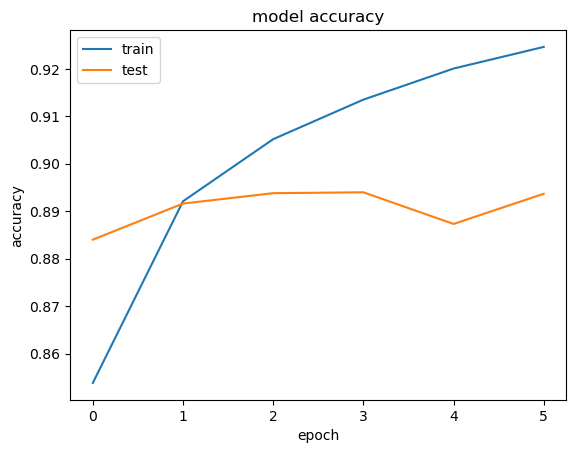

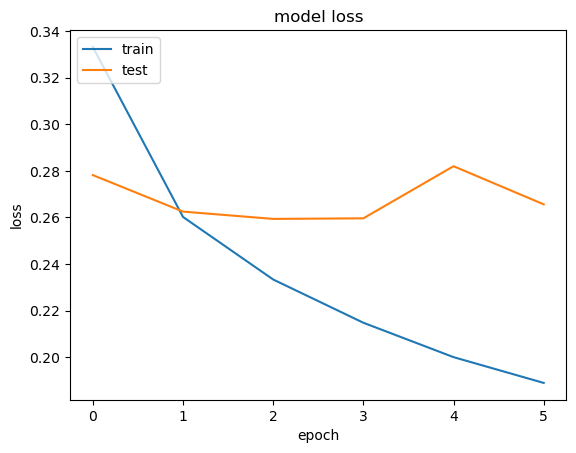

In [22]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [23]:
cnn_model.save('cnn_model.h5')